# Point clouds

In this tutorial, we cover how to instantiate and use a PointCloud. This is the kind of geometry which is most used. It is made of two arrays of points in any
dimension and a distance or cost function.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.core import sinkhorn

## Creates a PointCloud (made of two point clouds)

In [2]:
rng = jax.random.PRNGKey(0)
rngs = jax.random.split(rng, 4)

n, m, d = 12, 14, 2
x = jax.random.normal(rngs[0], (n,d)) + 1
y = jax.random.uniform(rngs[1], (m,d))
a = jax.random.uniform(rngs[2], (n,))
b = jax.random.uniform(rngs[3], (m,))
a, b  = a / jnp.sum(a), b / jnp.sum(b)

## Computes the regularized optimal transport

In [3]:
geom = pointcloud.PointCloud(x,y)
out = sinkhorn.sinkhorn(geom, a, b)
P = geom.transport_from_potentials(out.f, out.g)

## Visualizes the transport

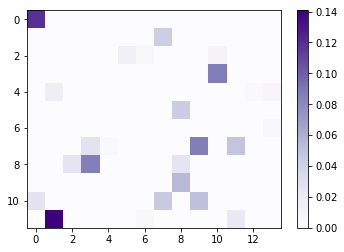

In [4]:
P = geom.transport_from_potentials(out.f, out.g)
plt.imshow(P, cmap='Purples')
plt.colorbar()

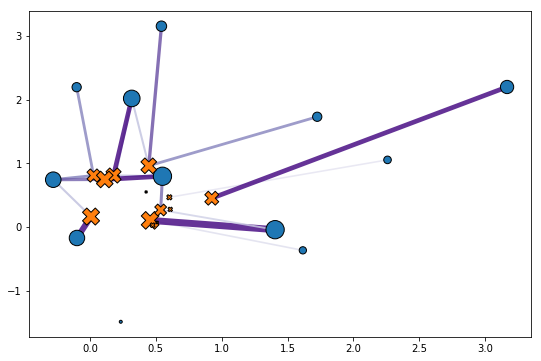

In [5]:
def plot_couplings(x, y, a, b, transport, threshold=1e-2):
    plt.figure(figsize=(9, 6))
    plt.scatter(*x.T, s=a*2000, edgecolors='k', marker='o', label='x')
    plt.scatter(*y.T, s=b*2000, edgecolors='k', marker='X', label='y')

    cmap = plt.get_cmap('Purples')
    u, v = jnp.where(transport > threshold)
    c = P[jnp.where(transport > threshold)]
    xy = jnp.concatenate([x[u], y[v]], axis=-1)  
    for i in range(xy.shape[0]):
        strength = jnp.max(jnp.array(P.shape)) * c[i]
        plt.plot(xy[i, [0, 2]], xy[i, [1, 3]],
                 linewidth=1 + strength*3,
                 color=cmap(strength),
                 zorder=0, alpha=0.8)

plot_couplings(x, y, a, b, P)